In [2]:
%load_ext autoreload
%autoreload 2

import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A

from dataset import *

    
json_p = Path('data/data_processed.json')

/home/tomas/miniconda3/envs/tomlynx/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


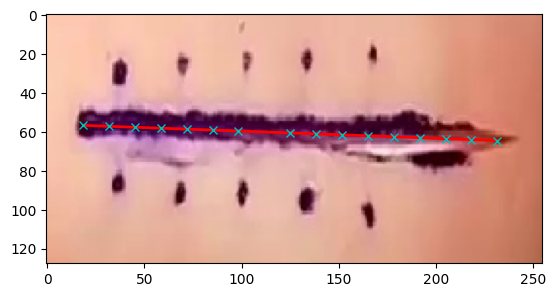

<Figure size 640x480 with 0 Axes>

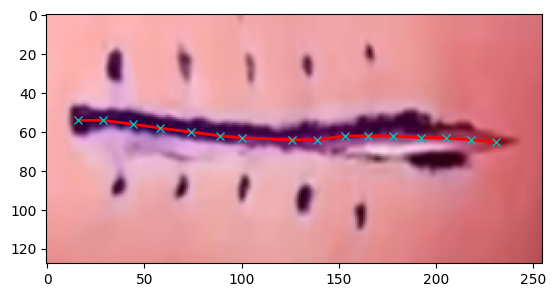

In [215]:
dataset = ZdoDataset(json_p)

img_id = '52'
image, incision = dataset.get_raw_item(img_id)

visualize(image,incision)

# augmentations

# blur transforms 
transform_blur = A.Compose([
    A.OneOf([
    A.AdvancedBlur(p=0.8),
    A.Blur(p=0.8), 
    A.GaussianBlur(p=0.8),
    A.MedianBlur(p=0.8),
    A.MotionBlur(p=0.8)
  ], p=1) 
], keypoint_params=A.KeypointParams(format='xy'))
# spatial transforms
# TODO: add vertical flip ... requires flipping the order of points as well ... separate transform 
# TODO: handle when keypoints outside of img probably condition on len(keypoinst) when forward passing
transform_geom = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.OneOf([
      A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=20, p=0.9),
      A.PiecewiseAffine(scale=(0.03, 0.05), p=0.9),
      A.Perspective(scale=(0.025, 0.05), p=0.9)  
    ], p=1)
], keypoint_params=A.KeypointParams(format='xy'))

transform_color = A.Compose([
    A.OneOf([
        A.ChannelDropout(p=0.8),
        A.ColorJitter(p=0.8),
        A.HueSaturationValue(p=0.8),
        A.RGBShift(p=0.8),
        A.RandomBrightnessContrast(p=0.8)
    ], p=1)
])
transform = A.Compose([transform_geom, transform_color, transform_blur])

# transform = transform_color
transformed = transform(image=image, keypoints=incision)
plt.figure()
visualize(transformed['image'], transformed['keypoints'])

tensor(-1., dtype=torch.float64) tensor(0.6719, dtype=torch.float64)


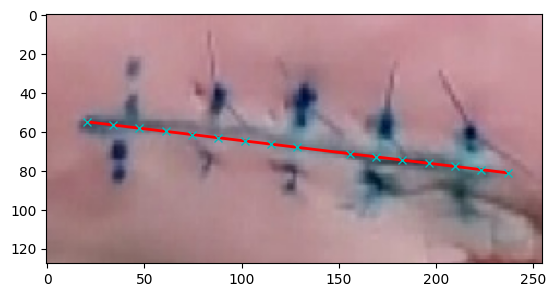

In [104]:
# define the transformations
transform = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    # to [-1,1]
    #A.transforms.Normalize(mean=[0,0,0], std=[1,1,1], max_pixel_value=255.0),  
], keypoint_params=A.KeypointParams(format='xy'))


dataset = ZdoDataset(json_p, transform=None)
# TODO: train val test into separate jsons
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

dataiter = iter(dataloader)
images, labels = next(dataiter)

print(images[0].min(), images[0].max())
# TODO: only incision supported atm
imvis = visualize_tensor(images[0], labels[0], unnormalize=True)